In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder


In [2]:
train = pd.read_csv(r"data/train.csv")
test = pd.read_csv(r"data/test.csv")
sample_submission = pd.read_csv(r"data/sample_submission.csv")

sample_submission.head()

target_col = 'Listening_Time_minutes'

# Handle missing values

In [3]:
mask = train[target_col] == 0.0
train[mask] = train[mask].replace(0, np.nan)

In [4]:
# Check for missing values
print("\nMissing values in training set:")
train.isnull().sum()


Missing values in training set:


id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146032
Number_of_Ads                    1580
Episode_Sentiment                   0
Listening_Time_minutes           8551
dtype: int64

In [5]:
def create_preprocessor(numerical_cols, categorical_cols):
    preprocessor = ColumnTransformer(
        transformers=[
            # Impute missing numerical values with median
            ('num', SimpleImputer(strategy='median'), numerical_cols),
            
            # Impute missing categorical values AND one-hot encode in one step
            ('cat', 
             Pipeline([
                 ('imputer', SimpleImputer(strategy='most_frequent')),
                 ('encoder', OneHotEncoder(handle_unknown='ignore'))
             ]), 
             categorical_cols)
        ]
    )
    return preprocessor

- separete the columns

In [6]:
numerical_cols = train[test.columns].select_dtypes(include=['int64', 'float64']).columns
categorical_cols = train[test.columns].select_dtypes(include=['object']).columns

In [7]:

for df in [train, test]:
    # Fill numerical columns with median grouped by Podcast_Name
    for col in numerical_cols:
        df[col] = df.groupby('Podcast_Name')[col].transform(lambda x: x.fillna(x.median()))

    # Fill categorical columns with mode grouped by Podcast_Name 
    for col in categorical_cols:
        if col in ['Podcast_Name', 'Episode_Title']:
            continue
        df[col] = df.groupby('Podcast_Name')[col].transform(lambda x: x.fillna(x.mode()[0]))

In [8]:
train[target_col] = train.groupby('Podcast_Name')[target_col].transform(lambda x: x.fillna(x.median()))

In [9]:
# Check for missing values
print("\nMissing values in training set:")
train.isnull().sum()


Missing values in training set:


id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
Listening_Time_minutes         0
dtype: int64

# todo
- aplicar feature engineering combinado com a solucao antiga e com o notebook de referenicia - aplicado
https://www.kaggle.com/code/satyaprakashshukl/predict-podcast-listening-time
- dropar as colunas de titulo e nome do podcast - n foi necessario ainda
- aplicar one hot encoder 
- aplicar feature importance atraves de metodo alternativo ao de arvores
- aplicar standard scaler
- verificar multicolinearidade
- aplicar o kfold no modelo
- criar a pipeline 
- gerar a submission

# observacoes
- pesquisar influencia de one hot encoder, get_dummies e LabelEncoder para regressão linear
    - one hote encoder deixa muito complexo pra modelo linear, LabelEncoder leva a confusao e get_dumies é a melhor opcao
- refazer o feature engineering considerando:
    - Publication_Time and Publication_Day cyclical features using sine and cosine transformations ok
    - extract the number episode and apply features using sine and cosine transformations ok
    - For categorical variables like Genre and Podcast_Name:
        Use pd.get_dummies() or One-Hot Encoding
        Consider grouping rare categories into an "Other" category if there are too many unique values

In [10]:
# for col in categorical_cols:
#     one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
#     # Fit and transform the data
#     encoded_data = one_hot_encoder.fit_transform(train[[col]])  # Note double brackets to keep it as 2D
#     # Convert to DataFrame
#     encoded_df = pd.DataFrame(encoded_data, columns=one_hot_encoder.get_feature_names_out([col]))
#     # Concatenate with original DataFrame
#     train = pd.concat([train, encoded_df], axis=1)

In [11]:
# train = train.drop(categorical_cols, axis=1)

# Feature Engineering

In [12]:
numerical_cols = train[test.columns].select_dtypes(include=['int64', 'float64']).columns
categorical_cols = train[test.columns].select_dtypes(include=['object']).columns

In [13]:
def get_bins(data):
    # Calculate quartile values
    q1 = data.quantile(0.25)
    q2 = data.quantile(0.50) 
    q3 = data.quantile(0.75)

    # Create bins using quartiles
    bins = [-np.inf, q1, q2, q3, np.inf]
    return bins

In [14]:
def calculate_thresholds(df):
    thresholds = {
        'episode_length_quantile': df['Episode_Length_minutes'].quantile(0.75),
        'host_popularity_quantile': df['Host_Popularity_percentage'].quantile(0.75),
        'guest_popularity_quantile': df['Guest_Popularity_percentage'].quantile(0.75),
        'ads_quantile': df['Number_of_Ads'].quantile(0.75),
        'episode_length_bins': get_bins(df['Episode_Length_minutes'])
    }
    return thresholds


In [15]:
def label_encoding(df_train, df_test, col):
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.transform(df_test[col]) 

In [16]:

def feature_engineering(df, train_df=None):
    if train_df is not None:
        thresholds = calculate_thresholds(train_df)
    else:
        thresholds = calculate_thresholds(df)
    
    # Features that don't depend on training data
    # df['Is_Weekend'] = df['Publication_Day'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)
    df['Guest_Host_Popularity_Ratio'] = df['Guest_Popularity_percentage'] / (df['Host_Popularity_percentage'])
    # df['Ads_Per_Minute'] = (df['Number_of_Ads'] / df['Episode_Length_minutes']).fillna(0)
    # df['Host_Guest_Synergy'] = df['Host_Popularity_percentage'] * df['Guest_Popularity_percentage']

    df['Publication_Day'] = df['Publication_Day'].map({'Saturday': 0, 'Sunday': 1, 'Monday': 2, 'Tuesday': 3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6}).astype(int)
    df['Publication_Time'] = df['Publication_Time'].map({'Morning': 0, 'Afternoon': 1, 'Evening': 2, 'Night': 3}).astype(int)
    df['Episode_Number'] = df['Episode_Title'].str.extract('(\d+)').astype(int)

    # df['Publication_Time_sin'] = np.sin(df['Publication_Time'] * (2 * np.pi / 24))
    df['Publication_Time_cos'] = np.cos(df['Publication_Time'] * (2 * np.pi / 24))
    # df['Publication_Day_sin'] = np.sin(df['Publication_Day'] * (2 * np.pi / 7))
    df['Publication_Day_cos'] = np.cos(df['Publication_Day'] * (2 * np.pi / 7))
    df['Episode_Number_sin'] = np.cos(df['Episode_Number'] * (2 * np.pi / 100))

    # Features that depend on training data thresholds
    # df['Long_Episode'] = (df['Episode_Length_minutes'] > thresholds['episode_length_quantile']).astype(int)
    # df['Highly_Popular_Host'] = (df['Host_Popularity_percentage'] > thresholds['host_popularity_quantile']).astype(int)
    # df['Highly_Popular_Guest'] = (df['Guest_Popularity_percentage'] > thresholds['guest_popularity_quantile']).astype(int)
    # df['Host_Guest_Popularity_Sum'] = df['Guest_Popularity_percentage'] + df['Host_Popularity_percentage']
    # df['Episode_Length_Bin'] = pd.cut(df['Episode_Length_minutes'],
                                    # bins=thresholds['episode_length_bins'],
                                    # labels=[0, 1, 2, 3]).astype('category')
    # df['High_Ad_Load'] = (df['Number_of_Ads'] > thresholds['ads_quantile']).astype(int)
    
    return df

In [17]:
df_train = feature_engineering(train, train_df=None)
df_test = feature_engineering(test, train_df=train)

In [18]:
for df in [df_train, df_test]:
    df.drop(columns=['Publication_Time', 'Publication_Day', 'Episode_Title', 'Episode_Number', 'Podcast_Name'], inplace=True) # must drop 
    # df.drop(columns=['Number_of_Ads', 'Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage'], inplace=True)

In [19]:
df_test.select_dtypes(include=['object', 'category', 'string']).columns, df_train.select_dtypes(include=['object', 'category', 'string']).columns

(Index(['Genre', 'Episode_Sentiment'], dtype='object'),
 Index(['Genre', 'Episode_Sentiment'], dtype='object'))

In [20]:
# cols = df_train.select_dtypes(include=['object', 'category', 'string']).columns

# for col in cols:
#     label_encoding(df_train, df_test, col)

In [21]:
df_train.dtypes

id                               int64
Episode_Length_minutes         float64
Genre                           object
Host_Popularity_percentage     float64
Guest_Popularity_percentage    float64
Number_of_Ads                  float64
Episode_Sentiment               object
Listening_Time_minutes         float64
Guest_Host_Popularity_Ratio    float64
Publication_Time_cos           float64
Publication_Day_cos            float64
Episode_Number_sin             float64
dtype: object

In [22]:
categorical_cols = df_train.select_dtypes(include=['object', 'category']).columns

df_train = pd.get_dummies(df_train, columns=categorical_cols)
df_test = pd.get_dummies(df_test, columns=categorical_cols)

In [23]:
# bool_cols = df_train.select_dtypes(include=['bool']).columns
# df_train[bool_cols] = df_train[bool_cols].astype(int)
# df_test[bool_cols] = df_test[bool_cols].astype(int)


# Feature Importance

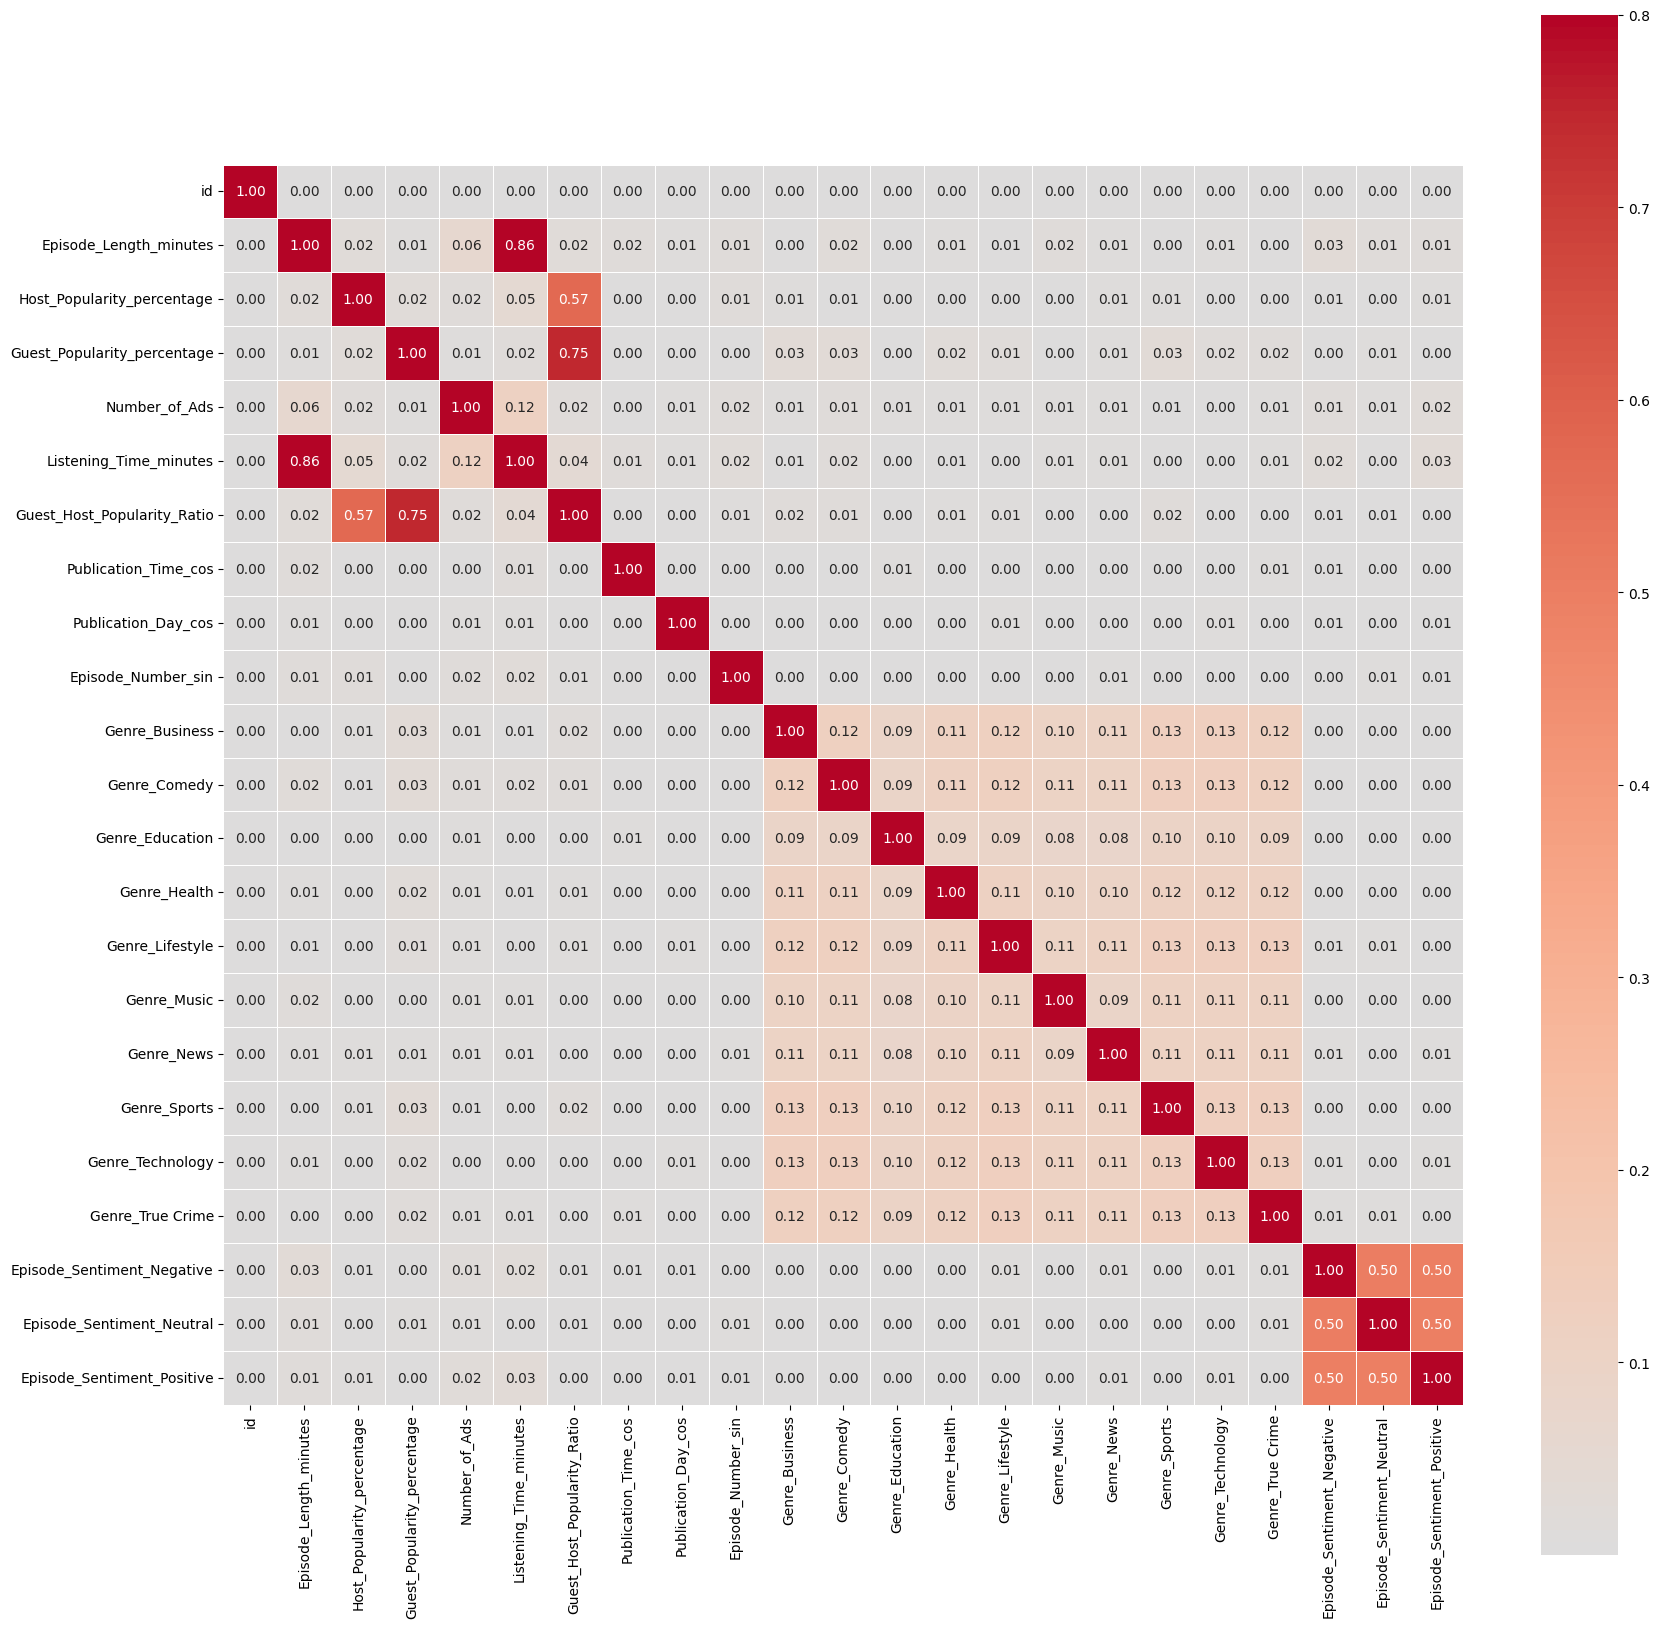

In [24]:
# Get categorical columns
# cols = df_train.columns.tolist()
# train_encoded = df_train[cols]

# # Calculate correlation with target variable
# correlation_matrix = train_encoded.corr(method='spearman')['Listening_Time_minutes'].abs().sort_values(ascending=True)
# correlation_matrix = correlation_matrix.drop('Listening_Time_minutes')  # Remove self-correlation

#correlation matrix
corrmat = df_train.corr(method='spearman').abs()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax=.8, square=True, cmap='coolwarm', annot=True, fmt='.2f', center=0, linewidths=0.5);

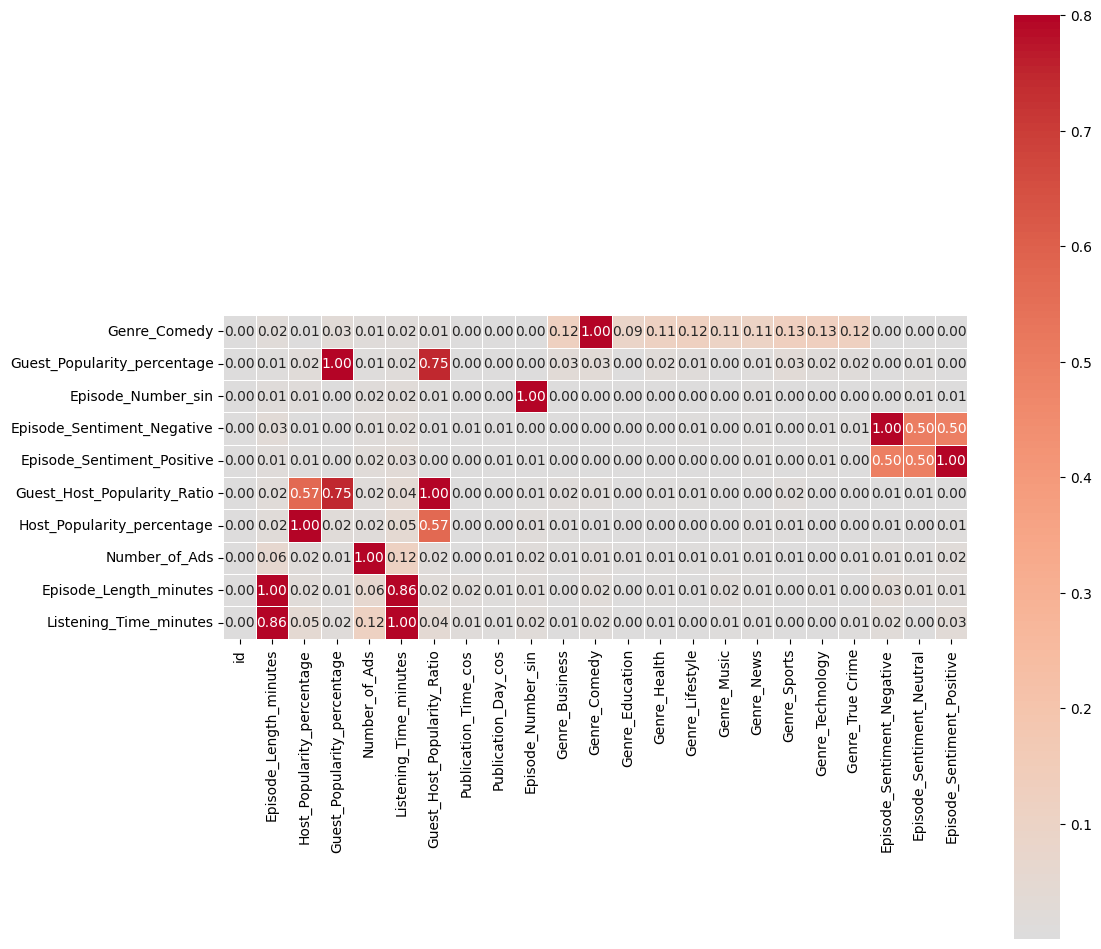

In [25]:
k = 10 #number of variables for heatmap
corrmat_2 = corrmat.nlargest(k, target_col).sort_values(by=[target_col])

# sns.set_theme(font_scale=1.25)
f, ax = plt.subplots(figsize=(12, 12))
hm = sns.heatmap(corrmat_2, vmax=.8, square=True, cmap='coolwarm', annot=True, fmt='.2f', center=0, linewidths=0.5);
plt.show()

In [26]:
filter_cols = ['Episode_Length_minutes', 'Number_of_Ads']

d:\repositorios_pessoais\podcast-listening-predictor\.venv\lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


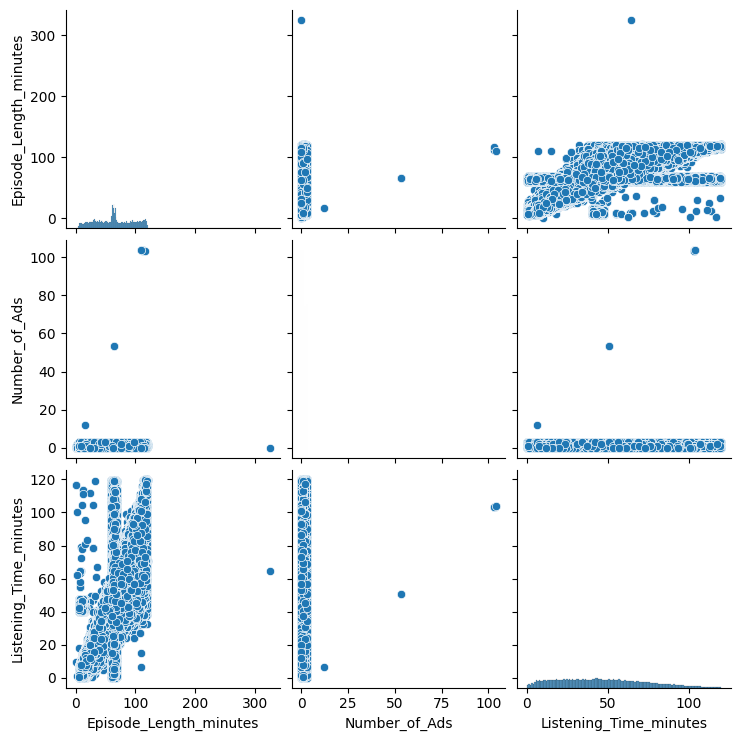

In [27]:
sns.pairplot(df_train[filter_cols + [target_col]], size = 2.5)
plt.show();

# Out liars

In [28]:

# Sort values and get 10 lowest and highest values
low_range = df_train[target_col].sort_values()[:10]
high_range = df_train[target_col].sort_values()[-10:]

print('outer range (low) of the distribution:')
print(list(low_range))
print('\nouter range (high) of the distribution:') 
print(list(high_range))

outer range (low) of the distribution:
[0.00056, 0.00056, 0.00056, 0.00056, 0.00056, 0.00056, 0.00056, 0.00175, 0.00175, 0.00175]

outer range (high) of the distribution:
[119.97, 119.97, 119.97, 119.97, 119.97, 119.97, 119.97, 119.97, 119.97, 119.97]


In [29]:
df_train.isna().sum()

id                             0
Episode_Length_minutes         0
Host_Popularity_percentage     0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Listening_Time_minutes         0
Guest_Host_Popularity_Ratio    0
Publication_Time_cos           0
Publication_Day_cos            0
Episode_Number_sin             0
Genre_Business                 0
Genre_Comedy                   0
Genre_Education                0
Genre_Health                   0
Genre_Lifestyle                0
Genre_Music                    0
Genre_News                     0
Genre_Sports                   0
Genre_Technology               0
Genre_True Crime               0
Episode_Sentiment_Negative     0
Episode_Sentiment_Neutral      0
Episode_Sentiment_Positive     0
dtype: int64

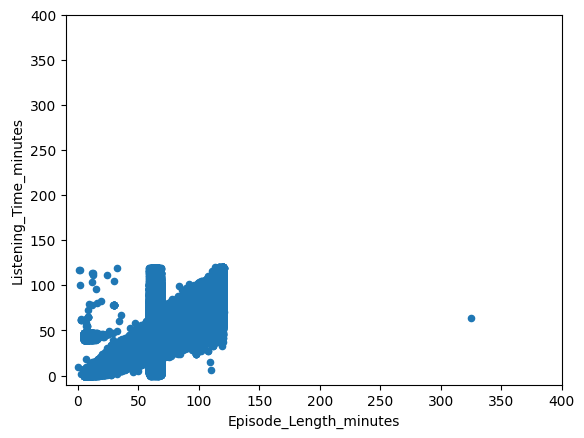

In [30]:
var = filter_cols[0]
data = pd.concat([df_train[target_col], df_train[var]], axis=1)
data.plot.scatter(x=var, y=target_col, ylim=(-10,400), xlim=(-10,400));

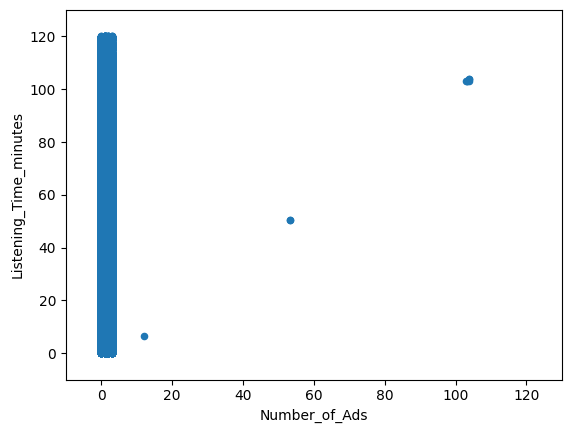

In [31]:
var = filter_cols[1]
data = pd.concat([df_train[target_col], df_train[var]], axis=1)
data.plot.scatter(x=var, y=target_col, ylim=(-10,130), xlim=(-10,130));

 # Normality

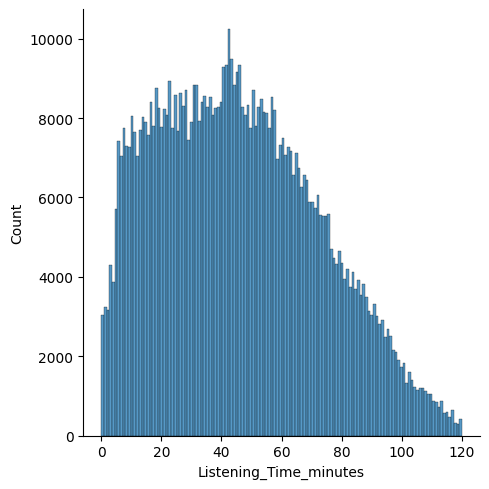

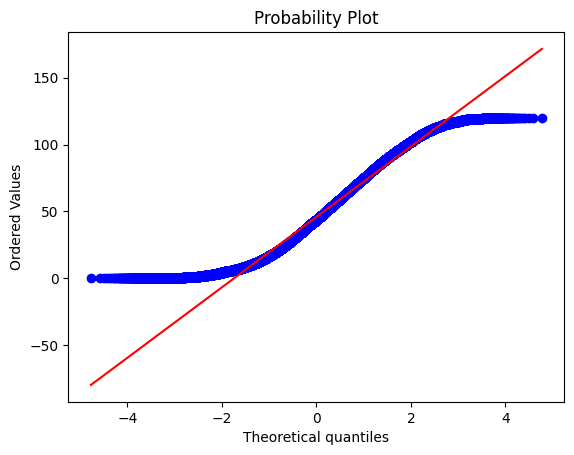

In [32]:
#histogram and normal probability plot
from matplotlib.pylab import norm
from scipy import stats


sns.displot(df_train[target_col]);
fig = plt.figure()
res = stats.probplot(df_train[target_col], plot=plt)

In [33]:
df_train[target_col], lambda_value = stats.boxcox(df_train[target_col])

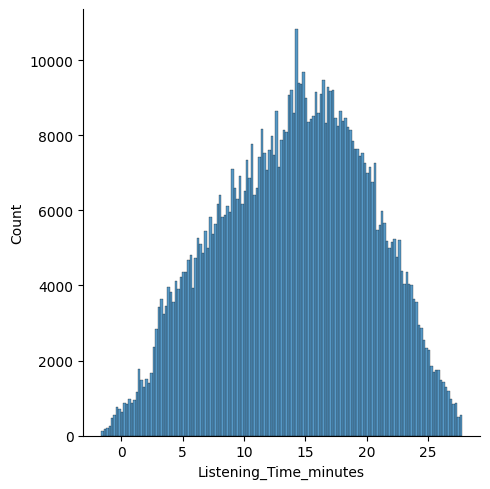

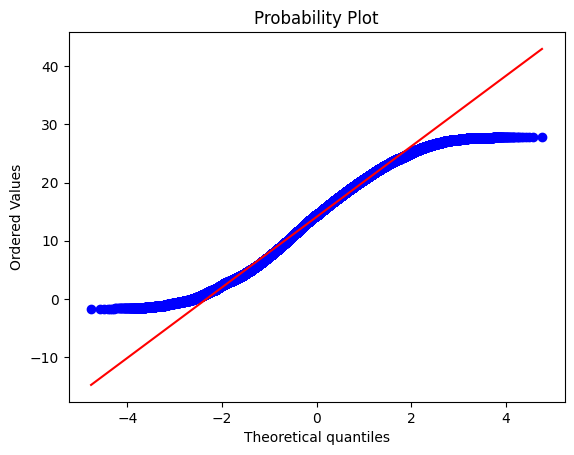

In [34]:

sns.displot(df_train[target_col]);
fig = plt.figure()
res = stats.probplot(df_train[target_col], plot=plt)

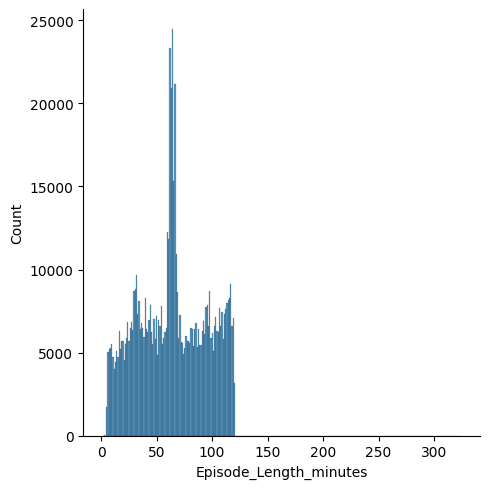

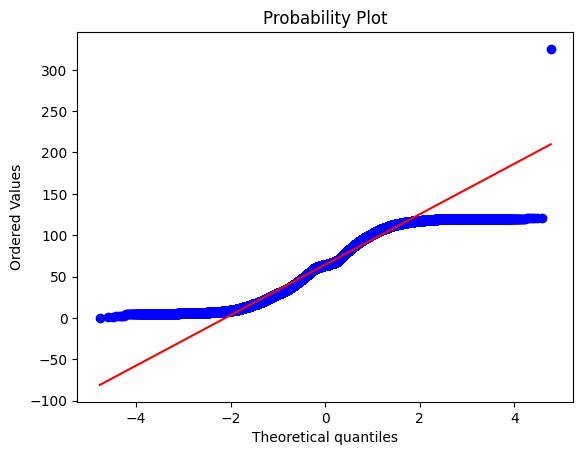

In [35]:

sns.displot(df_train[filter_cols[0]]);
fig = plt.figure()
res = stats.probplot(df_train[filter_cols[0]], plot=plt)

In [36]:
df_train[filter_cols[0]].min()

np.float64(0.0)

In [37]:
df_train[filter_cols[0]], lambda_value_ep_lenght = stats.boxcox(df_train[filter_cols[0]] + 0.0005)
df_test[filter_cols[0]] = stats.boxcox(df_test[filter_cols[0]] + 0.0005, lambda_value_ep_lenght)

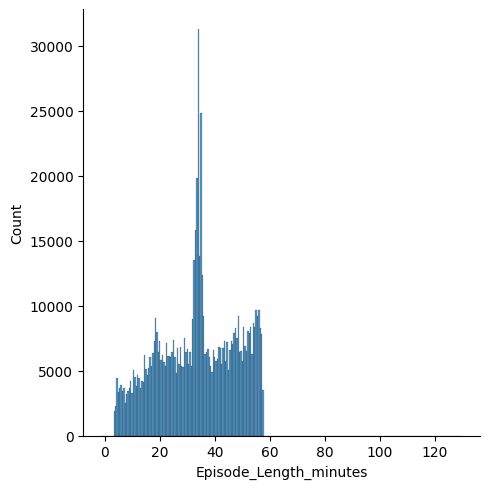

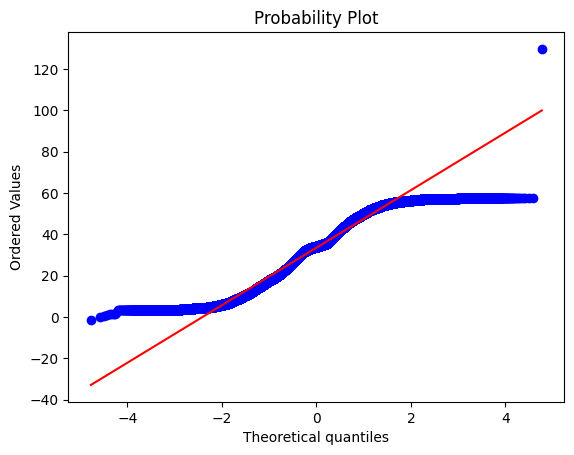

In [38]:

sns.displot(df_train[filter_cols[0]]);
fig = plt.figure()
res = stats.probplot(df_train[filter_cols[0]], plot=plt)

In [39]:
filter_cols[:1]

['Episode_Length_minutes']

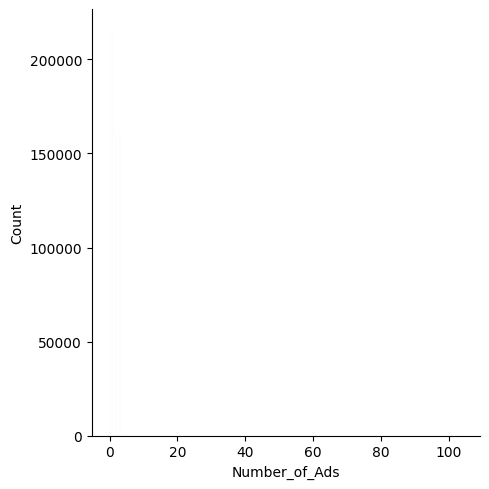

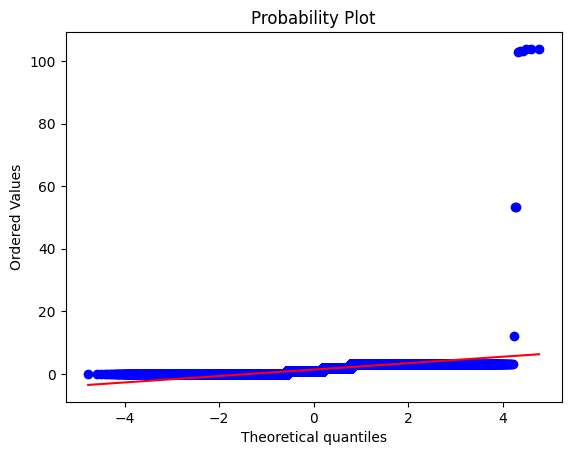

In [40]:
sns.displot(df_train[filter_cols[1]] + 0.0005);
fig = plt.figure()
res = stats.probplot(df_train[filter_cols[1]] + 0.0005, plot=plt)

In [41]:
df_train[filter_cols[1]], lambda_value_ads = stats.boxcox(df_train[filter_cols[1]] + 0.0005)
df_test[filter_cols[1]] = stats.boxcox(df_test[filter_cols[1]] + 0.0005, lambda_value_ads)

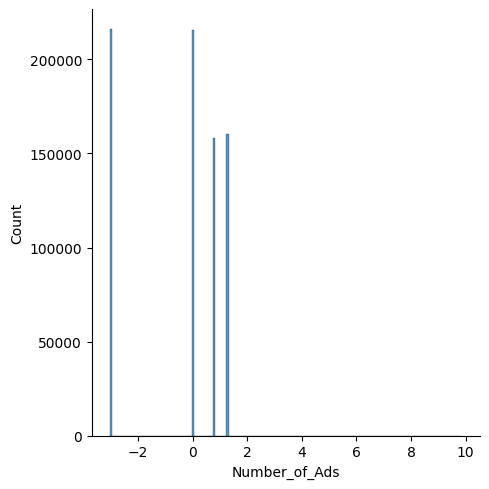

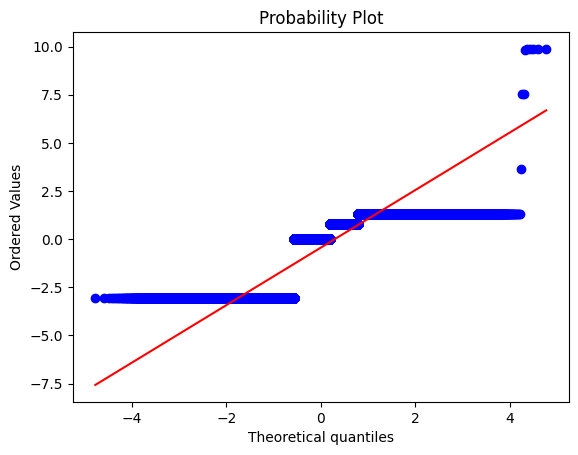

In [42]:

sns.displot(df_train[filter_cols[1]]);
fig = plt.figure()
res = stats.probplot(df_train[filter_cols[1]], plot=plt)

In [43]:
from sklearn.model_selection import train_test_split


X = df_train[filter_cols]
y = df_train[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .33, random_state = 0)

In [44]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((502500, 2), (502500,), (247500, 2), (247500,))

In [45]:
## Call in the LinearRegression object
lin_reg = LinearRegression(n_jobs=-1)
## fit train and test data. 
lin_reg.fit(X_train, y_train)
## Predict test data.
y_pred = lin_reg.predict(X_test)

In [46]:
print ('%.4f'%mean_squared_error(y_test, y_pred))

9.8550


In [47]:
from sklearn.model_selection import KFold, cross_val_score


cv = KFold(shuffle=True, random_state=2, n_splits=10)
scores = cross_val_score(lin_reg, X,y,cv = cv, scoring = 'neg_mean_absolute_error')
print ('%.8f'%scores.mean())
print ('%.8f'%scores.std())

-2.30319510
0.00739904


In [48]:
## Call in the LinearRegression object
lin_reg_1 = LinearRegression(n_jobs=-1)
## fit train and test data.
lin_reg_1.fit(X, y)
## Predict test data. 
y_pred = lin_reg_1.predict(df_test[filter_cols])

In [49]:
# Create submission file
submission = pd.DataFrame({
    'id': df_test['id'],
    'Listening_Time_minutes': stats.boxcox(y_pred, lambda_value)
})

# Check for invalid values in predictions
print(f"Min prediction: {submission['Listening_Time_minutes'].min()}")
print(f"Max prediction: {submission['Listening_Time_minutes'].max()}")
print(f"Any NaN values: {submission['Listening_Time_minutes'].isna().sum()}")
submission['Listening_Time_minutes'] = submission['Listening_Time_minutes'].fillna(submission['Listening_Time_minutes'].median())
# Save the submission file
submission.to_csv(r'data/submission_linear_regression_wih_2_feature.csv', index=False)
print("Submission file created successfully!")

Min prediction: 1.0533577590490832
Max prediction: 6750.842245750142
Any NaN values: 1
Submission file created successfully!


In [ ]:
train_encoded = train.drop(columns=['Episode_Title', 'Podcast_Name', 'id'])


# Get categorical columns
categorical_cols = train_encoded.select_dtypes(include=['object', 'category']).columns.tolist()

# Create dummy variables for categorical features
train_encoded = pd.get_dummies(train_encoded, columns=categorical_cols)

filter_features = combined_importance.Feature.tolist()
filter_features.append('Listening_Time_minutes')
train_encoded = train_encoded[filter_features]

train_encoded = train_encoded.fillna(train_encoded.median())

# Prepare data (X = features, y = target)
X = train_encoded.drop('Listening_Time_minutes', axis=1)
y = train_encoded['Listening_Time_minutes']

In [ ]:

# Get feature importance
# Option 1: Using built-in feature importance (weight)
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(15, 20))
sns.barplot(x='Importance', y='Feature', data=importance)
plt.title('XGBoost Feature Importance for Listening Time Prediction')
plt.tight_layout()
plt.show()

# Option 2: Get feature importance with gain (improvement in accuracy)
importance_gain = model.get_booster().get_score(importance_type='gain')
importance_gain = pd.DataFrame({
    'Feature': list(importance_gain.keys()),
    'Importance': list(importance_gain.values())
}).sort_values('Importance', ascending=False)

# Plot gain-based importance
plt.figure(figsize=(15, 20))
sns.barplot(x='Importance', y='Feature', data=importance_gain)
plt.title('XGBoost Gain-Based Feature Importance')
plt.tight_layout()
plt.show()

# Filter the original dataframes to only include these common important features

In [ ]:
# Get top 20 features from each importance metric
top20_weight = importance.sort_values('Importance', ascending=False).head(20)['Feature'].tolist()
top20_gain = importance_gain.sort_values('Importance', ascending=False).head(20)['Feature'].tolist()

# Find common features between both top 20 lists
common_top_features = list(set(top20_weight) & set(top20_gain))
print(f"Number of common features in top 20: {len(common_top_features)}")
print(f"Common features: {common_top_features}")

# Filter the original dataframes to only include these common features
common_importance = importance[importance['Feature'].isin(common_top_features)].sort_values('Importance', ascending=False)
common_importance_gain = importance_gain[importance_gain['Feature'].isin(common_top_features)].sort_values('Importance', ascending=False)

# Create a combined visualization of these common important features
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Weight-based importance
sns.barplot(x='Importance', y='Feature', data=common_importance, ax=ax1)
ax1.set_title('Top Features (Weight-Based Importance)')

# Gain-based importance
sns.barplot(x='Importance', y='Feature', data=common_importance_gain, ax=ax2)
ax2.set_title('Top Features (Gain-Based Importance)')

plt.tight_layout()
plt.show()

# Create a combined DataFrame for clearer comparison
combined_importance = pd.DataFrame({
    'Feature': common_top_features,
    'Weight_Importance': [importance[importance['Feature'] == f]['Importance'].values[0] for f in common_top_features],
    'Gain_Importance': [importance_gain[importance_gain['Feature'] == f]['Importance'].values[0] for f in common_top_features]
})

# Normalize

# Model Training


## XGBoost

In [17]:

filter_features = combined_importance.Feature.tolist()
filter_features.append('Listening_Time_minutes')
train_encoded = train_encoded[filter_features]

# Get categorical columns
categorical_cols = train_encoded.select_dtypes(include=['object', 'category']).columns.tolist()

# Create dummy variables for categorical features
train_encoded = pd.get_dummies(train_encoded, columns=categorical_cols)

# Prepare data (X = features, y = target)
X = train_encoded.drop('Listening_Time_minutes', axis=1)
y = train_encoded['Listening_Time_minutes']

In [18]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1862)


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    # For dataset with skewed listening time target
    'max_depth': [3, 4, 5, 6],              # Balance between complexity and overfitting
    # 'learning_rate': [0.05, 0.1, 0.2],       # Good balance for your dataset size
    'n_estimators': [100, 200, 300],         # Higher for large dataset
    
    # For handling mixed categorical and numerical features
    # 'min_child_weight': [3, 5, 7, 9, 11],       # Higher to handle missing values robustly
    # 'subsample': [0.8, 0.9, 1.0],            # Good for large dataset
    'colsample_bytree': [0.8, 0.9, 1.0],     # Handle many dummy variables from encoding
    
    # For regularization
    'gamma': [0.1, 0.2, 0.3],                # Moderate pruning for podcast feature relationships
    # 'reg_alpha': [0.001, 0.01, 0.1],          # L1 regularization for feature selection
    # 'reg_lambda': [1.0, 1.5, 2.0],           # Standard L2 regularization

}

# Create base model
xgb_model = xgb.XGBRegressor(
    random_state=1862,
    missing=np.nan,
    eval_metric='rmse',
    gpu_id=0,
    n_jobs=-1
)

# Initialize Grid Search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='neg_root_mean_squared_error'
)

# Fit Grid Search
grid_search.fit(X, y)

# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: {-grid_search.best_score_:.4f}")


In [ ]:

# Train final model with best parameters
best_model = xgb.XGBRegressor(
    **grid_search.best_params_,
    random_state=1862,
    missing=np.nan,
    eval_metric='rmse',
    n_jobs=-1
)
best_model.fit(X, y)

In [ ]:
model = best_model

#Load the test data
test = pd.read_csv(r"data/test.csv")
sample_submission = pd.read_csv(r"data/sample_submission.csv")

# Preprocess test data exactly the same way as training data


# Fill missing values (use training data for medians)
test = fill_missing_by_podcast_median(test, 'Episode_Length_minutes', train)
test = fill_missing_by_podcast_median(test, 'Guest_Popularity_percentage', train)

# Create the same features you created for training data
# Example feature engineering (adjust based on your actual features)

test['Ad_Density'] = test['Number_of_Ads'] / test['Episode_Length_minutes'].replace(0, np.nan)
test['Is_Weekend'] = test['Publication_Day'].isin(['Saturday', 'Sunday']).astype(bool)
test['Host_Guest_Popularity_Gap'] = test['Host_Popularity_percentage'] - test['Guest_Popularity_percentage']
test['Host_Guest_Synergy'] = test['Host_Popularity_percentage'] * test['Guest_Popularity_percentage']
test['Day_Time_Publication_Interaction'] = test['Publication_Day'] + '_' + test['Publication_Time']

test = test.drop(columns=['Episode_Title', 'Podcast_Name'])

# Handle categorical features - use same encoding as training
# Get categorical columns
categorical_cols = test.select_dtypes(include=['object', 'category']).columns.tolist()

# Create dummy variables consistent with training data
test_encoded = pd.get_dummies(test, columns=categorical_cols)

# Make predictions
predictions = model.predict(test_encoded[X.columns])

# Create submission file
submission = pd.DataFrame({
    'id': test_encoded['id'],
    'Listening_Time_minutes': predictions
})

# Check for invalid values in predictions
print(f"Min prediction: {submission['Listening_Time_minutes'].min()}")
print(f"Max prediction: {submission['Listening_Time_minutes'].max()}")
print(f"Any NaN values: {submission['Listening_Time_minutes'].isna().sum()}")

# Save the submission file
submission.to_csv(r'data/submission_xgboost_gridsearch_after_first_try.csv', index=False)
print("Submission file created successfully!")

# 8. Verify the format matches the sample submission
print("\nVerifying submission format:")
print(f"Sample submission shape: {sample_submission.shape}")
print(f"Your submission shape: {submission.shape}")
assert submission.shape == sample_submission.shape, "Submission shape doesn't match sample!"
assert all(submission.columns == sample_submission.columns), "Column names don't match sample!"
print("Submission format looks correct!")

# submission_first_try.csv
- Score in train data: 13.0943
- Score in kaggle submission: 13.19384

# submission_xgboost_gridsearch_after_first_try
- Score in train data: 13.0537
- Score in kaggle submission: 13.17141

**This leaderboard is calculated with approximately 20% of the test data. The final results will be based on the other 80%, so the final standings may be different!**

## Simple Linear Regression

In [17]:
train_encoded = train.drop(columns=['Episode_Title', 'Podcast_Name', 'id'])


# Get categorical columns
categorical_cols = train_encoded.select_dtypes(include=['object', 'category']).columns.tolist()

# Create dummy variables for categorical features
train_encoded = pd.get_dummies(train_encoded, columns=categorical_cols)

filter_features = combined_importance.Feature.tolist()
filter_features.append('Listening_Time_minutes')
train_encoded = train_encoded[filter_features]

train_encoded = train_encoded.fillna(train_encoded.median())

# Prepare data (X = features, y = target)
X = train_encoded.drop('Listening_Time_minutes', axis=1)
y = train_encoded['Listening_Time_minutes']

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# 2. Separate numerical and categorical features
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['uint8']).columns  # dummy variables

# 3. Scale numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# 4. Fit linear regression
model = LinearRegression()
model.fit(X, y)

In [ ]:
# Load test data
test = pd.read_csv("data/test.csv")

# Fill missing values (use training data for medians)
test = fill_missing_by_podcast_median(test, 'Episode_Length_minutes', train)
test = fill_missing_by_podcast_median(test, 'Guest_Popularity_percentage', train)

# Create the same features you created for training data
# Example feature engineering (adjust based on your actual features)

test['Ad_Density'] = test['Number_of_Ads'] / test['Episode_Length_minutes'].replace(0, np.nan)
test['Is_Weekend'] = test['Publication_Day'].isin(['Saturday', 'Sunday']).astype(bool)
test['Host_Guest_Popularity_Gap'] = test['Host_Popularity_percentage'] - test['Guest_Popularity_percentage']
test['Host_Guest_Synergy'] = test['Host_Popularity_percentage'] * test['Guest_Popularity_percentage']
test['Day_Time_Publication_Interaction'] = test['Publication_Day'] + '_' + test['Publication_Time']

test = test.drop(columns=['Episode_Title', 'Podcast_Name'])

# Handle categorical features - use same encoding as training
# Get categorical columns
categorical_cols = test.select_dtypes(include=['object', 'category']).columns.tolist()

# Create dummy variables consistent with training data
test_encoded = pd.get_dummies(test, columns=categorical_cols)

# Scale numerical features using the same scaler from training
test_encoded[numerical_cols] = scaler.transform(test_encoded[numerical_cols])

# Make predictions
test_predictions = model.predict(test_encoded[X.columns])

# Create submission file
submission = pd.DataFrame({
    'id': test['id'],
    'Listening_Time_minutes': test_predictions
})

# Save submission file
submission.to_csv('data/submission_linear_regression_with_feat_impt.csv', index=False)

# Verify submission format
print("\nVerifying submission format:")
print(f"Number of predictions: {len(test_predictions)}")
print(f"Min prediction: {submission['Listening_Time_minutes'].min()}")
print(f"Max prediction: {submission['Listening_Time_minutes'].max()}")
print(f"Any NaN values: {submission['Listening_Time_minutes'].isna().sum()}")
assert submission.shape == sample_submission.shape, "Submission shape doesn't match sample!"
assert all(submission.columns == sample_submission.columns), "Column names don't match sample!"
print("Submission format looks correct!")

# submission_linear_regression.csv
- Score in train data:
- Score in kaggle submission: 13.44347

# submission_linear_regression_with_feat_impt
- Score in train data: 13.0537
- Score in kaggle submission: 13.5864

**This leaderboard is calculated with approximately 20% of the test data. The final results will be based on the other 80%, so the final standings may be different!**